# Significantly improved accuracy by normalizing spectra prior to NN

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import decimal
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace as st
from sklearn.model_selection import train_test_split

print(tf.__version__)

1.10.0


In [2]:
def smart_round(value, style="0.001"):
    """Round a float correctly, returning a string."""
    tmp = decimal.Decimal(value).quantize(decimal.Decimal(style))
    return str(tmp)

## Dataset: ISO-SWS

In [3]:
# Needed directories
base_dir = '../data/isosws_atlas/'

# Pickles containing our spectra in the form of pandas dataframes:
spec_dir = base_dir + 'spectra/'
spec_files = np.sort(glob.glob(spec_dir + '*.pkl'))

# Metadata pickle (pd.dataframe). Note each entry contains a pointer to the corresponding spectrum pickle.
metadata = base_dir + 'metadata.pkl'

In [4]:
# Load the metadata pickle.
meta = pd.read_pickle(metadata)

In [5]:
meta

,object_name,tdt,ra,dec,full_classifier,group,subgroup,uncertainty_flag,note,,file_path,object_type,data_ok
0,W Cet,37802225,0.532083,-14.676639,2.SEa:,2,SEa,1,,,spectra/37802225_sws.pkl,S*,True
1,SV And,42801007,1.083333,40.110333,2.SEa:,2,SEa,1,,,spectra/42801007_sws.pkl,Mira,True
2,SV And,80800708,1.083333,40.110333,2.SEa,2,SEa,,,,spectra/80800708_sws.pkl,Mira,True
3,CIT 1,78201008,1.717917,43.076667,7,7,,,W,,spectra/78201008_sws.pkl,Mira,True
4,HR 10,37802001,1.825833,-17.387000,1.NM:,1,NM,1,,,spectra/37802001_sws.pkl,Star,True
5,{beta} Cas,28501420,2.293625,59.149944,1.N,1,N,,,,spectra/28501420_sws.pkl,Star,True
6,V633 Cas,43501514,2.860833,58.834444,5.SE,5,SE,,W,,spectra/43501514_sws.pkl,Ae*,True
7,NGC 40,44401917,3.253792,72.522222,4.PN,4,PN,,,,spectra/44401917_sws.pkl,PN,True
8,NGC 40,30003803,3.254583,72.521972,4.PN,4,PN,,,,spectra/30003803_sws.pkl,PN,True
9,HR 48,55502138,3.660000,-18.932889,1.NO,1,NO,,,,spectra/55502138_sws.pkl,Candidate_LP*,True


### Labels

In [6]:
# Simple classifier first.
labels = meta['group'].values.astype(int)

In [7]:
# The possible labels.
np.unique(labels)

array([1, 2, 3, 4, 5, 6, 7])

In [8]:
# SHIFTING TO START AT ZERO!
labels = labels - 1

#### Labels ('group'):

1. Naked stars
2. Stars with dust
3. Warm, dusty objects
4. Cool, dusty objects
5. Very red objects
6. Continuum-free objects but having emission lines
7. Flux-free and/or fatally flawed spectra

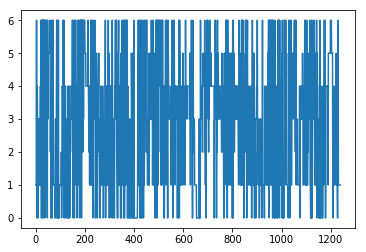

In [9]:
# See how the labels are distributed.
plt.plot(labels);

In [10]:
# Shuffle data at some point.

In [11]:
type(labels[0])

numpy.int64

In [12]:
# Make sure each sample has a valid label.
np.sum(np.isfinite(labels)) == len(labels)

True

In [13]:
len(labels)

1239

In [14]:
# knowing that each sample has a 359-point vector/spectrum.
features = np.zeros((len(labels), 359))

### Features

In [44]:
def load_spectrum(path):
    df = pd.read_pickle(path)
    flux = df['flux']
    
    # IMPORTANT!
    # Scale the fluxes.
    tmp_flux = flux + np.nanmin(flux)
    tmp_flux = tmp_flux / np.nanmax(tmp_flux) # should be between [0, 1] now
    
#     return tmp_flux
    return flux / np.nanmax(flux)

index = 0
# Fill the 'spectra' variable with the astronomical data.
for row in meta.itertuples(index=True, name='Pandas'):
    flux = load_spectrum(base_dir + row.file_path)
    features[index] = flux
    index += 1

In [45]:
features.shape

(1239, 359)

In [46]:
maxvec = np.nanmax(features, axis=1)

# Split into training and test sets

Data as...
- feaatures (1239, 359)
- labels (1239)

In [47]:
X_train, X_test, y_train, y_test = \
train_test_split(features, labels, test_size=0.33, random_state = 22)

In [48]:
X_train.shape

(830, 359)

In [49]:
X_test.shape

(409, 359)

In [50]:
y_train.shape

(830,)

In [51]:
y_test.shape

(409,)

# Model 1. NN (now with EarlyStopping)

In [80]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(64, activation='relu'))
# Add another:
model.add(keras.layers.Dense(64, activation='relu'))
# Add another:
model.add(keras.layers.Dense(64, activation='relu'))
# Add another:
model.add(keras.layers.Dense(32, activation='relu'))
# Add a softmax layer with 7 output units:
model.add(keras.layers.Dense(7, activation='softmax'))

In [81]:
model.compile(optimizer=tf.train.AdamOptimizer(0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='acc', patience=4, verbose=0),
#     ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]

In [83]:
model.fit(features, labels, epochs=50, batch_size=32,
          callbacks=callback)

Epoch 1/50
1239/1239 [==============================] - 0s 292us/step - loss: 1.6195 - acc: 0.4011
Epoch 2/50
1239/1239 [==============================] - 0s 60us/step - loss: 1.1847 - acc: 0.5811
Epoch 3/50
1239/1239 [==============================] - 0s 60us/step - loss: 1.0217 - acc: 0.6231
Epoch 4/50
1239/1239 [==============================] - 0s 63us/step - loss: 0.9163 - acc: 0.6610
Epoch 5/50
1239/1239 [==============================] - 0s 56us/step - loss: 0.8564 - acc: 0.6715
Epoch 6/50
1239/1239 [==============================] - 0s 62us/step - loss: 0.7941 - acc: 0.7046
Epoch 7/50
1239/1239 [==============================] - 0s 63us/step - loss: 0.7572 - acc: 0.7086
Epoch 8/50
1239/1239 [==============================] - 0s 55us/step - loss: 0.7171 - acc: 0.7304
Epoch 9/50
1239/1239 [==============================] - 0s 60us/step - loss: 0.6716 - acc: 0.7377
Epoch 10/50
1239/1239 [==============================] - 0s 59us/step - loss: 0.6501 - acc: 0.7546
Epoch 11/50
1239/1

#### Test accuracy

In [84]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

409/409 [==============================] - 0s 271us/step
Test accuracy: 0.9388753066436003


#### Check predictions

In [85]:
predictions = model.predict(X_test)

In [86]:
predicted_groups = [np.argmax(x) for x in predictions]

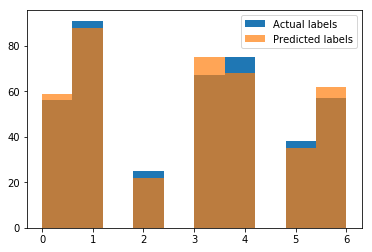

In [87]:
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_groups, label='Predicted labels', alpha=0.7);
plt.legend(loc=0)

# Model 2. stochastic gradient descent

http://scikit-learn.org/stable/modules/sgd.html

In [82]:
from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(loss="hinge", penalty="l2")

In [196]:
def sgd(X_train, y_train, X_test, y_test,
        alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', max_iter=20000, n_iter=None,
        n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
        shuffle=True, tol=None, verbose=0, warm_start=False,    
        **kwargs):
    
    # Stochastic gradient descent instance.
    clf = SGDClassifier(alpha=alpha, average=average, class_weight=class_weight,
                        epsilon=epsilon, eta0=eta0, fit_intercept=fit_intercept,
                        l1_ratio=l1_ratio, learning_rate=learning_rate, loss=loss,
                        max_iter=max_iter, n_iter=n_iter, n_jobs=n_jobs, penalty=penalty,
                        power_t=power_t, random_state=random_state, shuffle=shuffle,
                        tol=tol, verbose=verbose, warm_start=warm_start, **kwargs)

    # Fit!
    clf.fit(X_train, y_train);
    
    # Measure test accuracy.
    predicted_labels = clf.predict(X_test)
    test_acc = np.sum(predicted_labels == y_test) / len(y_test)
    
    return test_acc, clf

#### Model parameter search

In [219]:
# Number of iterations
iterations = np.arange(10, 10000, 500)

for index, value in enumerate(iterations):
    acc, _ = sgd(X_train, y_train, X_test, y_test,
                 max_iter=value)
    print('Accuracy, iterations: ', smart_round(acc), value)

Accuracy, iterations:  0.609 10
Accuracy, iterations:  0.672 510
Accuracy, iterations:  0.665 1010
Accuracy, iterations:  0.680 1510
Accuracy, iterations:  0.687 2010
Accuracy, iterations:  0.670 2510
Accuracy, iterations:  0.670 3010
Accuracy, iterations:  0.677 3510
Accuracy, iterations:  0.682 4010
Accuracy, iterations:  0.675 4510
Accuracy, iterations:  0.660 5010
Accuracy, iterations:  0.677 5510
Accuracy, iterations:  0.675 6010
Accuracy, iterations:  0.667 6510
Accuracy, iterations:  0.670 7010
Accuracy, iterations:  0.670 7510
Accuracy, iterations:  0.667 8010
Accuracy, iterations:  0.675 8510
Accuracy, iterations:  0.658 9010
Accuracy, iterations:  0.670 9510


Conclusion: converges surprisingly quickly.

In [156]:
# Loss function
losses = ['hinge', 'log', 'modified_huber', 'squared_hinge',
          'perceptron', 'squared_loss', 'huber',
          'epsilon_insensitive', 'squared_epsilon_insensitive']

for index, value in enumerate(losses):
    acc, _ = sgd(X_train, y_train, X_test, y_test,
                 max_iter=2000,
                 loss=value)
    print('Accuracy, loss: ', smart_round(acc), value)

Accuracy, loss:  0.599 hinge
Accuracy, loss:  0.633 log
Accuracy, loss:  0.601 modified_huber
Accuracy, loss:  0.601 squared_hinge
Accuracy, loss:  0.623 perceptron
Accuracy, loss:  0.103 squared_loss
Accuracy, loss:  0.264 huber
Accuracy, loss:  0.076 epsilon_insensitive
Accuracy, loss:  0.205 squared_epsilon_insensitive


Conclusion: stick to hinge (default), log or perceptron.

In [158]:
# Penalty
penalties = ['l2', 'l1', 'elasticnet']

for index, value in enumerate(penalties):
    acc, _ = sgd(X_train, y_train, X_test, y_test,
                 max_iter=2000, loss='hinge',
                 penalty=value)
    print('Accuracy, penalty: ', smart_round(acc), value)

Accuracy, penalty:  0.623 l2
Accuracy, penalty:  0.562 l1
Accuracy, penalty:  0.645 elasticnet


Conclusion: probably stick to l2 (default), also try elasticnet occasionally.

In [169]:
# Alpha (multiplies penalty term). Default: 0.0001
alphas = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for index, value in enumerate(alphas):
    acc, _ = sgd(X_train, y_train, X_test, y_test,
                 max_iter=2000, loss='hinge', penalty='l2',
                 alpha=value)
    print('Accuracy, alpha: ', smart_round(acc), value)

Accuracy, alpha:  0.724 1e-12
Accuracy, alpha:  0.724 1e-11
Accuracy, alpha:  0.719 1e-10
Accuracy, alpha:  0.726 1e-09
Accuracy, alpha:  0.711 1e-08
Accuracy, alpha:  0.716 1e-07
Accuracy, alpha:  0.716 1e-06
Accuracy, alpha:  0.714 1e-05
Accuracy, alpha:  0.633 0.0001
Accuracy, alpha:  0.557 0.001
Accuracy, alpha:  0.689 0.01
Accuracy, alpha:  0.606 0.1


Conclusion: stick to 1e-6 (lower than the default of 1e-4).

#### Selecting among best parameters

L2 penalty...

In [192]:
acc, _ = sgd(X_train, y_train, X_test, y_test,
             max_iter=2000, loss='hinge', penalty='l2', alpha=1e-6)
print('Accuracy: ', smart_round(acc))

Accuracy:  0.699


In [194]:
acc, _ = sgd(X_train, y_train, X_test, y_test,
             max_iter=2000, loss='log', penalty='l2', alpha=1e-6)
print('Accuracy: ', smart_round(acc))

Accuracy:  0.716


In [191]:
acc, _ = sgd(X_train, y_train, X_test, y_test,
             max_iter=2000, loss='perceptron', penalty='l2', alpha=1e-6)
print('Accuracy: ', smart_round(acc))

Accuracy:  0.716


Elasticnet penalty...

In [188]:
acc, _ = sgd(X_train, y_train, X_test, y_test,
             max_iter=2000, loss='hinge', penalty='elasticnet', alpha=1e-6)
print('Accuracy: ', smart_round(acc))

Accuracy:  0.724


In [189]:
acc, _ = sgd(X_train, y_train, X_test, y_test,
             max_iter=2000, loss='log', penalty='elasticnet', alpha=1e-6)
print('Accuracy: ', smart_round(acc))

Accuracy:  0.726


In [190]:
acc, _ = sgd(X_train, y_train, X_test, y_test,
             max_iter=2000, loss='perceptron', penalty='elasticnet', alpha=1e-6)
print('Accuracy: ', smart_round(acc))

Accuracy:  0.726


Conclusion:
* use elasticnet penalty, loss doesn't matter (log), alpha=1e-6

#### Putting it all together, ramp up iterations.

In [215]:
# Run final SGD model.
acc, clf = sgd(X_train, y_train, X_test, y_test, n_jobs=-1,
               max_iter=5000, loss='log', penalty='elasticnet', alpha=1e-6)

# Accuracy.
predicted_labels = clf.predict(X_test)
print('Accuracy: ', smart_round(acc))

# Number of iterations (compare to max_iter):
print('Iterations: ', clf.n_iter_)

Accuracy:  0.650
Iterations:  5000


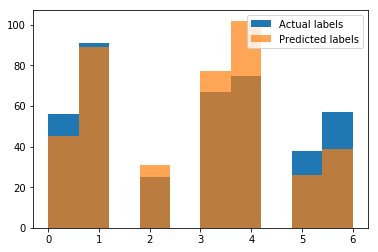

In [216]:
# Histogram of results.
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_labels, label='Predicted labels', alpha=0.7);
plt.legend(loc=0);

Conclusion:
* SGD can't match the capability of a NN for this problem (unless I have no idea what I'm doing with SGD here, which is entirely possible! :)

In [209]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

In [210]:
# Run final SGD model.
acc, clf = sgd(X_train, y_train, X_test, y_test, n_jobs=-1,
               max_iter=2000, loss='log', penalty='elasticnet', alpha=1e-6)

# Accuracy.
predicted_labels = clf.predict(X_test)
print('Accuracy: ', smart_round(acc))

# Number of iterations (compare to max_iter):
print('Iterations: ', clf.n_iter_)

Accuracy:  0.658
Iterations:  2000


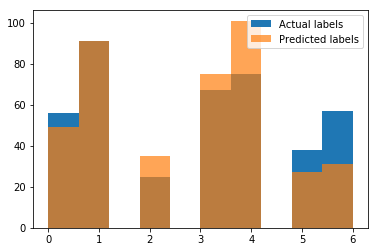

In [211]:
# Histogram of results.
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_labels, label='Predicted labels', alpha=0.7);
plt.legend(loc=0);